# SEE Filtering

## Python script that filters SEE = 0 from ECLASS-public dataset. 

_Requires eclass-public repo from https://github.com/Lewandowski-Labs-PER/eclass-public. Either download manually or git clone: https://github.com/Lewandowski-Labs-PER/eclass-public.git._

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Requires data-helper file to be saved in the same location as own analysis file
dh = importlib.import_module("eclass-public.DataHelper")


## Reading data

In [2]:
data = dh.eclass_data(route='eclass-public/')

# We are only interested in matched data

df = data.get_matched(unique_students=True).reset_index(
    drop=True)  # Matched responses of all students
# Matched responses of students in their first year/introductory courses
df_intro = data.get_intro_matched(unique_students=True).reset_index(drop=True)
df_buffy = data.get_buffy_matched(unique_students=True).reset_index(
    drop=True)  # Matched responses of students in beyond first year courses


c:\Users\micha\OneDrive - Imperial College London\US ECLASS\SEE\eclass-public\DataHelper.py:24: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.cis['StartDate'] = pd.to_datetime(self.cis['StartDate'])


## Grouping by student

In [3]:
# %%Creating a column that identifies whether a student was in an Intro (1) or BUFFY (2) course

ids = np.array(df['anon_student_id'])  # ids for all students
intro_ids = np.array(df_intro['anon_student_id'])
buffy_ids = np.array(df_buffy['anon_student_id'])
course_ids = np.array(df['survey_id_pre'])
buffy_course_ids = np.array(df_buffy['survey_id_pre'])
intro_course_ids = np.array(df_intro['survey_id_pre'])


for i in range(0, len(ids)):
    if (df.anon_student_id[i] in intro_ids) and (df.survey_id_pre[i] in intro_course_ids) == True:
        df.loc[df.index[i], 'CourseType'] = 1
    elif (df.anon_student_id[i] in buffy_ids) == True:
        df.loc[df.index[i], 'CourseType'] = 2

print(df.groupby('CourseType').anon_student_id.count())

CourseType
1.0    17749
2.0     2868
Name: anon_student_id, dtype: int64


## Obtaining IDs, calculating delta, shifting likert points scale

In [4]:

# First we obtain the question ids for each item, we'll use these to calculate each students E-CLASS & Delta score
preids = [x[:-1]
          for i, x in enumerate(data.pre_survey_question_ids) if i % 2 < 1]
a_pre = []
b_pre = []
a_post = []
b_post = []
for id in preids:
    a_pre.append(id + "a_pre")
    b_pre.append(id + "b_pre")
    a_post.append(id + "a_post")
    b_post.append(id + "b_post")
columns = a_pre+b_pre+a_post+b_post
columns.sort()

# Calculate delta scores using original 5-pt score
delta_ids = []
delta_ids_post = []
for id in preids:
    df["delta_pre"+id] = (df[id+"a_pre"] - df[id+"b_pre"])
    df["delta_post"+id] = (df[id+"a_post"] - df[id+"b_post"])
    delta_ids.append("delta_pre"+id)
    delta_ids_post.append("delta_post"+id)

# Converting data from 5-pt scale to 3-pt scale
df[columns] = df[columns].replace({5: 2, 4: 1, 3: 0, 2: -1, 1: -2})
df[columns] = df[columns].replace({2: 1, -2: -1})

for id in preids:
    # Calculates YOU item difference between pre and post score
    df["a_diff"+id] = (-df[id+"a_pre"] + df[id+"a_post"])
    # Calculates Expert item difference between pre and post score
    df["b_diff"+id] = (-df[id+"b_pre"] + df[id+"b_post"])

delta_columns = delta_ids+delta_ids_post
df[delta_columns] = df[delta_columns]

delta_columns = delta_columns+["Q54"]
delta_columns = delta_columns[:-1]

df['pre_delta_sum'] = df[delta_ids].apply(
    lambda x: x).sum(axis=1)  # Summing delta scores
df['post_delta_sum'] = df[delta_ids_post].apply(lambda x: x).sum(axis=1)

In [5]:
df_processed=df.copy()
df_processed[delta_ids] = df[delta_ids]
df_processed[delta_ids_post] = df[delta_ids_post]
df_processed[columns] = df[columns]

df_processed = df_processed.fillna(0) #Entries with "NA" replaced with 0

Now identify if for each survey item both responses to the YOU and Expert questions are the same for all items, then label that as invalid data.
Actually, what this does is check to see if the delta (SEE) score for each item is the same for all items (note this does not mean they answered the same to all questions) - practically it compares all SEE scores for each item with the score for the first item and then gives a True value if all items have the same SEE score.
Then the final validity is calculated by removing values where all items have the same SEE score AND the total SEE score is zero. This mainly removes the case where the response contains itemwise SEE values of zero and total SEE values of zero, but does not remove legitimate cases where the total SEE score is zero, but there is variation on each item.

In [6]:

df_delta_pre = df_processed[delta_ids]
df_delta_post = df_processed[delta_ids_post]
#print(df_delta_pre)

delta_tf_pre = df_delta_pre.eq(df_delta_pre.iloc[:, 0], axis=0).all(axis=1)

df_processed["DeltaEqualPre"] = delta_tf_pre
df_processed["DeltaEqualPre"] = df_processed["DeltaEqualPre"].replace(
    {False: 0, True: 1})  # 1 indicates that all items have the same SEE score, 0 says at least one is different

delta_tf_post = df_delta_post.eq(df_delta_post.iloc[:, 0], axis=0).all(axis=1)
df_processed["DeltaEqualPost"] = delta_tf_post
df_processed["DeltaEqualPost"] = df_processed["DeltaEqualPost"].replace({
                                                                        False: 0, True: 1})

for i in range(0, len(df_processed)):
    if (df_processed.DeltaEqualPre[i] == 1) and (df_processed.pre_delta_sum[i] == 0):
        df_processed.loc[df_processed.index[i], 'DeltaValidityPre'] = 1
    else:
        df_processed.loc[df_processed.index[i], 'DeltaValidityPre'] = 0

for i in range(0, len(df_processed)):
    if (df_processed.DeltaEqualPost[i] == 1) and (df_processed.post_delta_sum[i] == 0):
        df_processed.loc[df_processed.index[i], 'DeltaValidityPost'] = 1
    else:
        df_processed.loc[df_processed.index[i], 'DeltaValidityPost'] = 0

for i in range(0, len(ids)):  # filters through union of invalid students
    if (df_processed.DeltaValidityPre[i] == 1) or (df_processed.DeltaValidityPost[i] == 1):
        df_processed.loc[df_processed.index[i], 'DeltaValidity'] = 1
    else:
        df_processed.loc[df_processed.index[i], 'DeltaValidity'] = 0
# Selects just valid students
df_processed = df_processed[df_processed["DeltaValidity"] == 0]


C:\Users\micha\AppData\Local\Temp\ipykernel_15268\4188554499.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed["DeltaEqualPre"] = df_processed["DeltaEqualPre"].replace(
C:\Users\micha\AppData\Local\Temp\ipykernel_15268\4188554499.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed["DeltaEqualPost"] = df_processed["DeltaEqualPost"].replace({


## Plotting Pre-Post filtered SEE score

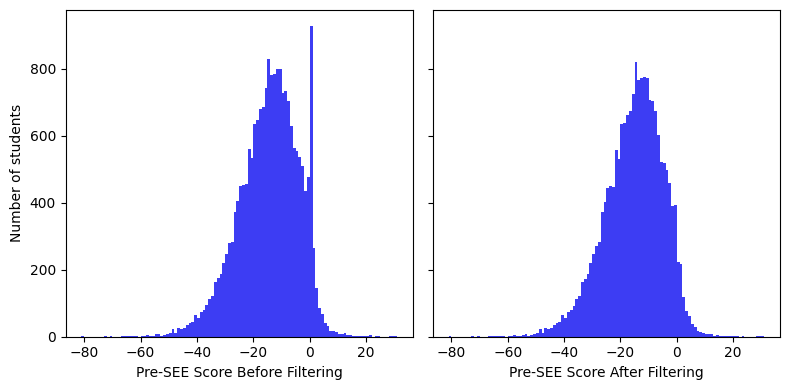

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))
delta_bins = np.arange(min(df['pre_delta_sum']), max(df['pre_delta_sum']), 1)
filter_delta_bins = np.arange(min(df_processed['pre_delta_sum']), max(df_processed['pre_delta_sum']), 1)
ax1.hist(df['pre_delta_sum'], bins=delta_bins, color="#3d3df3")
ax2.hist(df_processed['pre_delta_sum'], bins=filter_delta_bins, color="#3d3df3")
ax1.set_xlabel("Pre-SEE Score Before Filtering")
ax2.set_xlabel("Pre-SEE Score After Filtering")
ax1.set_ylabel("Number of students")
plt.tight_layout()


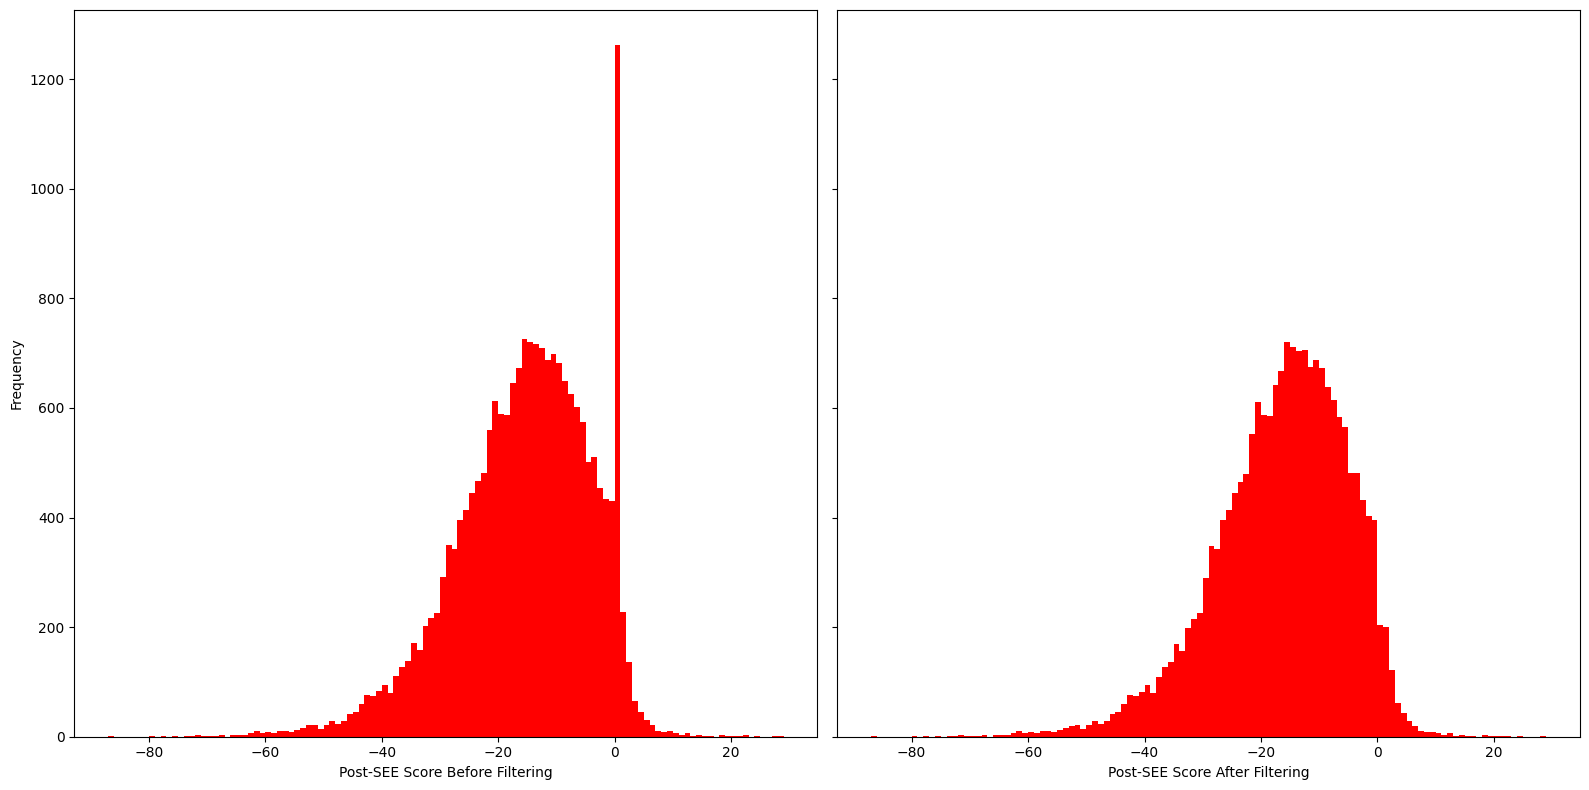

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
delta_bins = np.arange(min(df['post_delta_sum']), max(df['post_delta_sum']), 1)
filter_delta_bins = np.arange(min(df_processed['post_delta_sum']), max(df_processed['post_delta_sum']), 1)
ax1.hist(df['post_delta_sum'], bins=delta_bins, color="red")
ax2.hist(df_processed['post_delta_sum'], bins=filter_delta_bins, color="red")
ax1.set_xlabel("Post-SEE Score Before Filtering")
ax2.set_xlabel("Post-SEE Score After Filtering")
ax1.set_ylabel("Frequency")
plt.tight_layout()

# Look at whether the expert scores shift for each item

We need to just look at part 'b' of the questions and calculate the scores based on that - and compare pre/post

Before we do this, we have to map the question numbers that are relics of the Qualtrics survey to the actual questions numbers - see Zwickl 2014

In [9]:
zwickl_map = pd.read_excel("eclass-public/question_lookup.xlsx", sheet_name="anon_pre") # mapping is the same for pre/post
zwickl_map = zwickl_map[["Question ID","ThirtyQ"]].dropna()
# actually use the collapsed form so it goes uniformly from 1 - 30 (removing and shifting the validation question)
zwickl_dict = dict(zip(zwickl_map["Question ID"],zwickl_map["ThirtyQ"]))

SEE_pre_dict = dict(zip(['delta_pre'+x[0:3] for x in zwickl_map["Question ID"]],["Q"+x[:-1] for x in zwickl_map["ThirtyQ"]]))
SEE_post_dict = dict(zip(['delta_post'+x[0:3] for x in zwickl_map["Question ID"]],["Q"+x[:-1] for x in zwickl_map["ThirtyQ"]]))

        index  mean_exp_diff  sem_exp_diff  exp_diff_zero  mean_you_diff  \
9   b_diffq11       0.001770      0.001551           True       0.000208   
21  b_diffq23       0.006299      0.003372           True      -0.001458   
18  b_diffq20       0.011349      0.004332           True       0.006820   
25  b_diffq27       0.011817      0.002703           True      -0.004009   
13  b_diffq15       0.015670      0.003812           True      -0.009891   
19  b_diffq21       0.015878      0.003464           True      -0.001562   
24  b_diffq26       0.021552      0.002942           True      -0.016503   
14  b_diffq16       0.052267      0.006294           True      -0.002499   

    sem_you_diff  you_diff_zero  bigger_exp_shift   x  
9       0.001738          False              True  11  
21      0.003938          False              True  20  
18      0.004559           True              True  19  
25      0.004715          False              True   2  
13      0.005037           True    

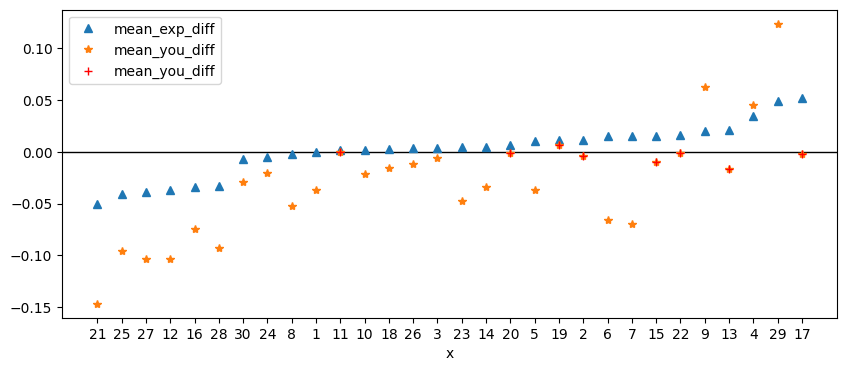

In [10]:
exp_diff_cols = []
you_diff_cols = []
new_labels = []
for id in preids:
    exp_diff_cols.append("b_diff"+id)
    you_diff_cols.append("a_diff"+id)
    new_labels.append(zwickl_dict[id+"a"].strip("a"))
    

exp_diff_means = pd.DataFrame([df_processed[exp_diff_cols].mean(axis=0),df_processed[exp_diff_cols].sem(axis=0)], index=["mean","sem"]).transpose()
exp_diff_means['diff_zero'] = (exp_diff_means["mean"].abs() - exp_diff_means["sem"].abs()) > 0

exp_diff_means.rename(columns={"mean":"mean_exp_diff","sem":"sem_exp_diff","diff_zero":"exp_diff_zero"},inplace=True)

you_diff_means = pd.DataFrame([df_processed[you_diff_cols].mean(axis=0),df_processed[you_diff_cols].sem(axis=0)], index=["mean","sem"]).transpose()
you_diff_means['diff_zero'] = (you_diff_means["mean"].abs() - you_diff_means["sem"].abs()) > 0

you_diff_means.rename(columns={"mean":"mean_you_diff","sem":"sem_you_diff","diff_zero":"you_diff_zero"},inplace=True)
you_diff_means.rename(index=dict(zip(you_diff_cols,exp_diff_cols)),inplace=True)


all_diff = pd.concat([exp_diff_means,you_diff_means],axis=1)
# identify which expert shifts are bigger than you shifts
all_diff['bigger_exp_shift'] = (all_diff['mean_exp_diff'].abs() - all_diff['mean_you_diff'].abs()) > 0

# create x axis


all_diff['x'] = new_labels

all_diff.reset_index(inplace=True)
print(all_diff[all_diff['bigger_exp_shift']].sort_values(by="mean_exp_diff"))

# sort
all_diff = all_diff.sort_values(by="mean_exp_diff").reset_index()


fig, ax = plt.subplots(figsize=(10,4))
all_diff.plot(y="mean_exp_diff", x='x', marker='^', linestyle="None", ax=ax)
all_diff.plot(y="mean_you_diff", x='x', marker='*', linestyle="None", ax=ax)




ax.axhline(y=0, color='k', linewidth=1, zorder=-100)
all_diff[all_diff['bigger_exp_shift']].plot(y="mean_you_diff", color='red', marker='+', linestyle="None", ax=ax)
#ax.plot(all_diff[all_diff['bigger_exp_shift']].x, all_diff[all_diff['bigger_exp_shift']].mean_you_diff, color='red', marker='+', linestyle="None")

# relabel the x axis after plotting everything
ax.set_xticks(np.arange(30))
ax.set_xticklabels(all_diff['x'].to_numpy())
plt.show()



# Gender split?
Now look at the distributions if we split by gender

In [11]:
print(df_processed.columns)

# export the processed data
df_processed.to_csv("see_processed.csv")

Index(['anon_student_id', 'survey_id_pre', 'duration_pre', 'q01a_pre',
       'q01b_pre', 'q27a_pre', 'q27b_pre', 'q03a_pre', 'q03b_pre', 'q22a_pre',
       ...
       'b_diffq30', 'a_diffq31', 'b_diffq31', 'pre_delta_sum',
       'post_delta_sum', 'DeltaEqualPre', 'DeltaEqualPost', 'DeltaValidityPre',
       'DeltaValidityPost', 'DeltaValidity'],
      dtype='object', length=303)


# Generate item distribution plots
Do the pre-test data first

c:\Users\micha\OneDrive - Imperial College London\US ECLASS\SEE\.venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


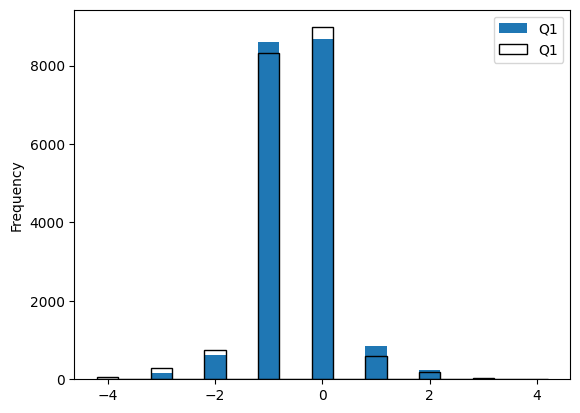

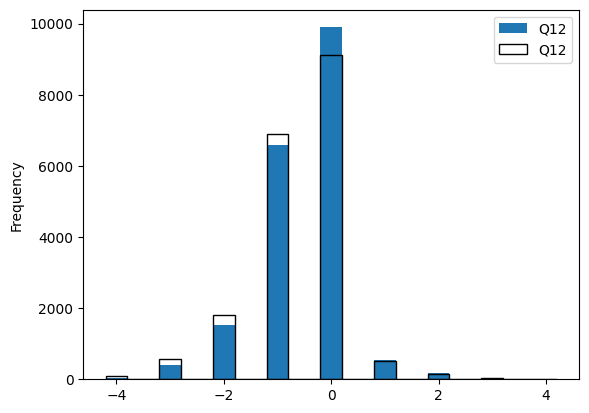

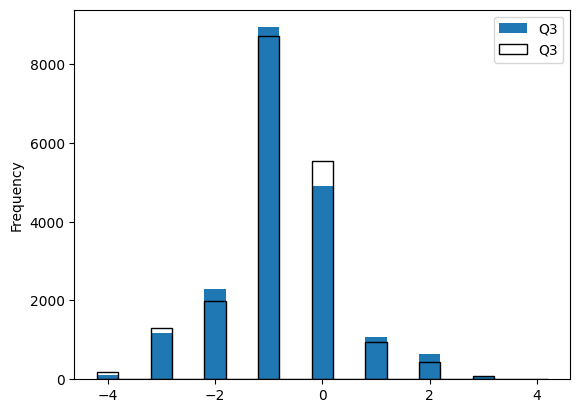

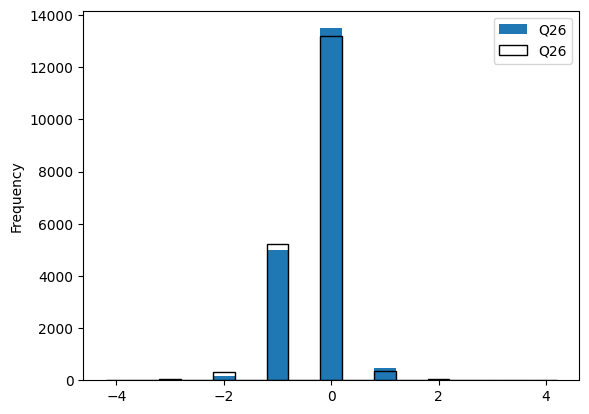

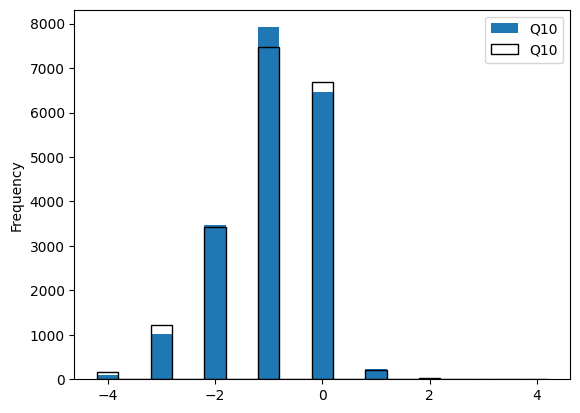

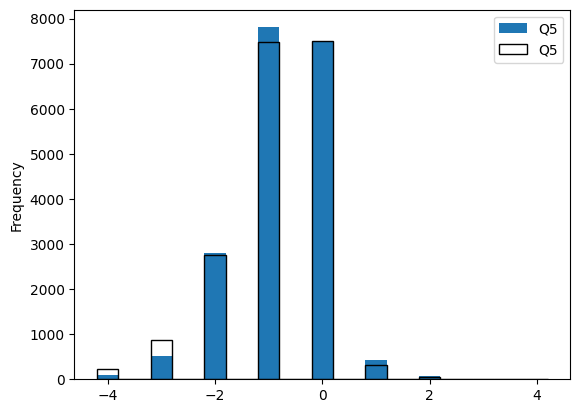

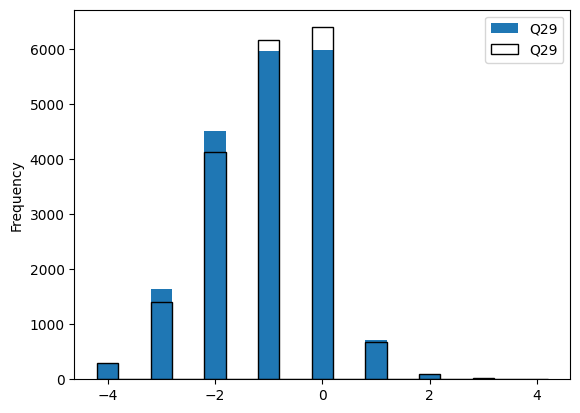

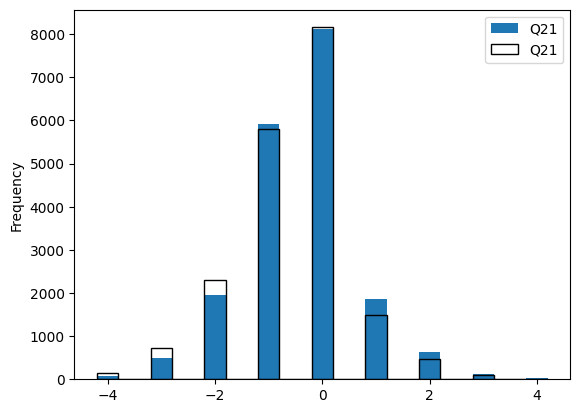

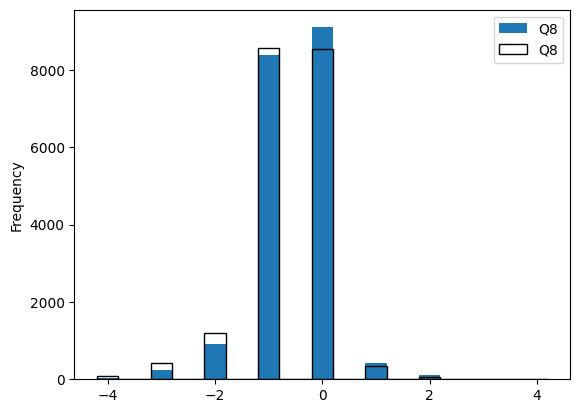

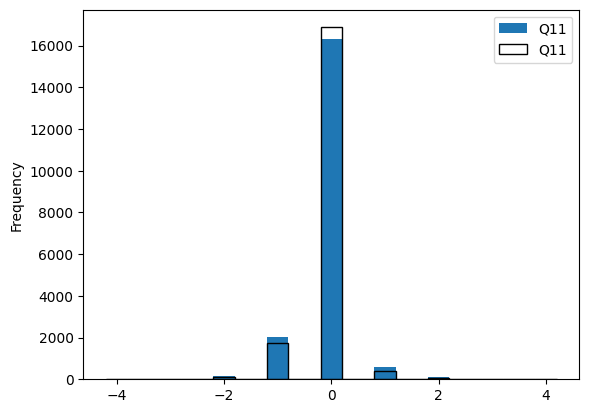

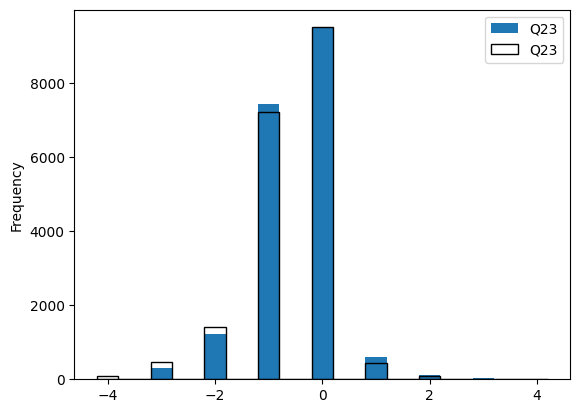

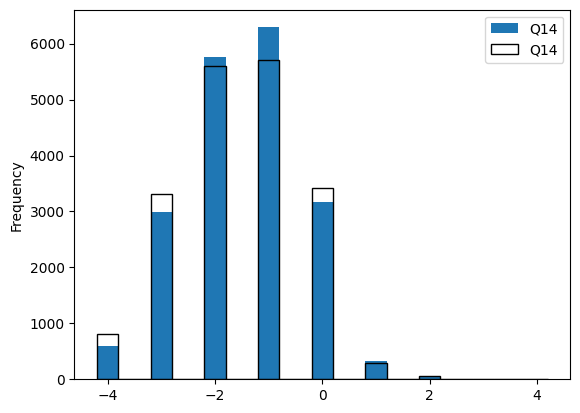

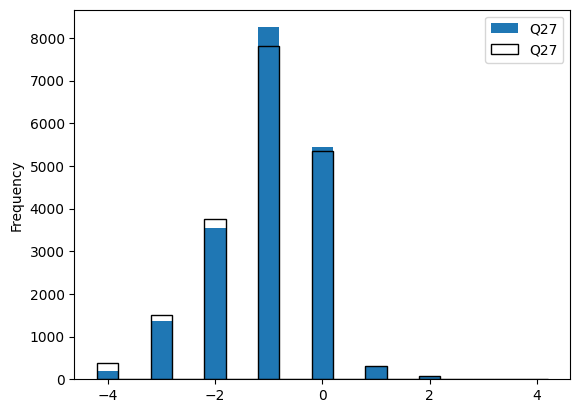

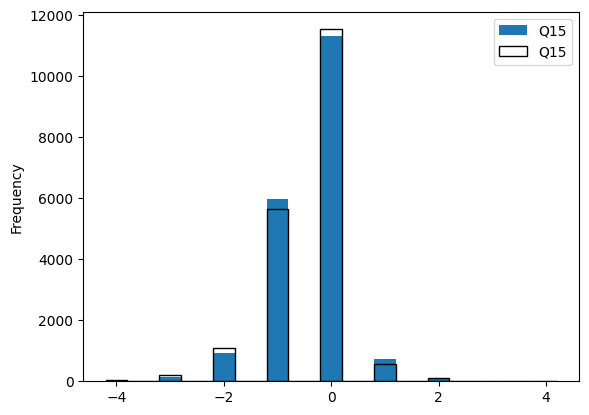

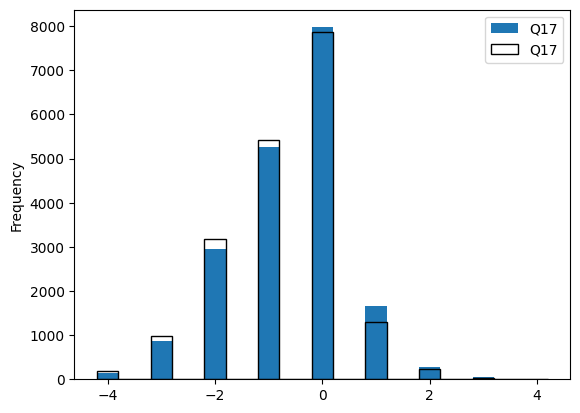

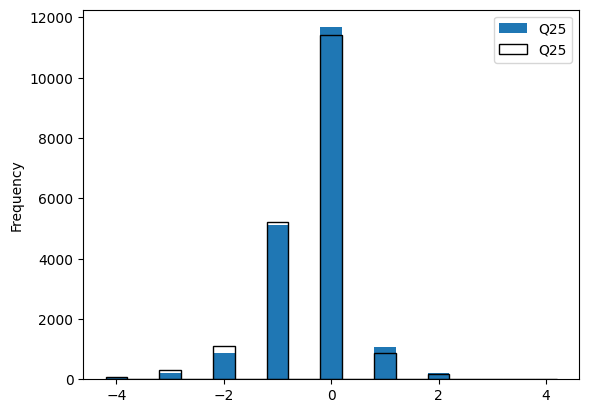

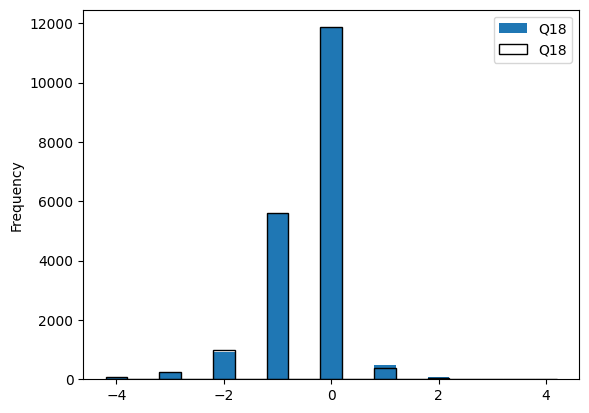

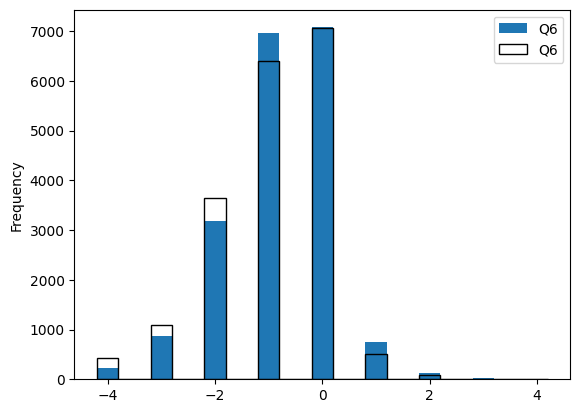

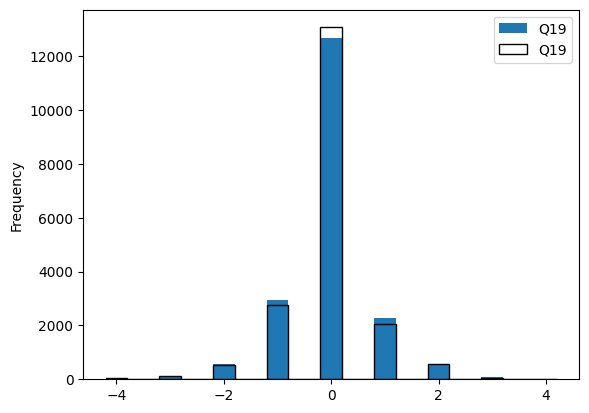

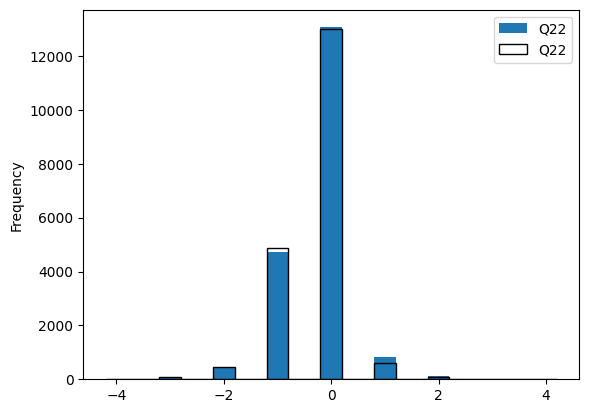

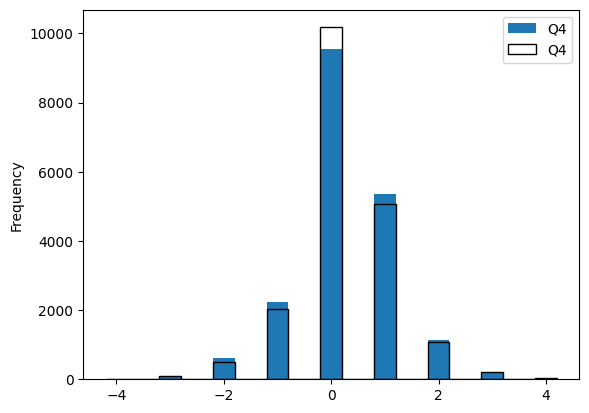

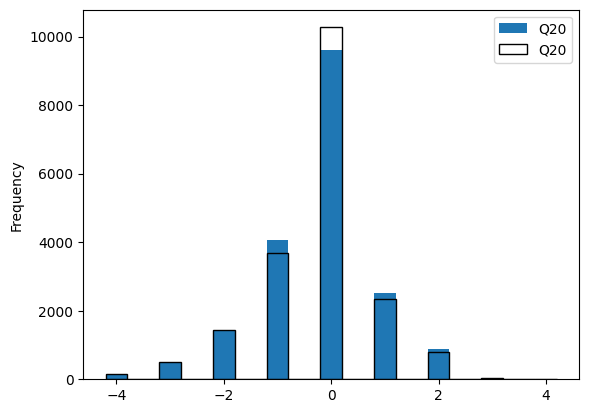

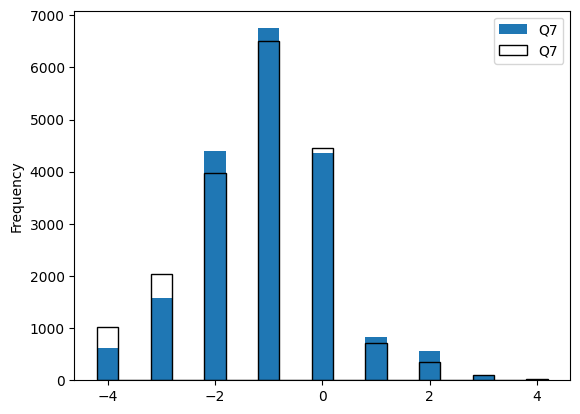

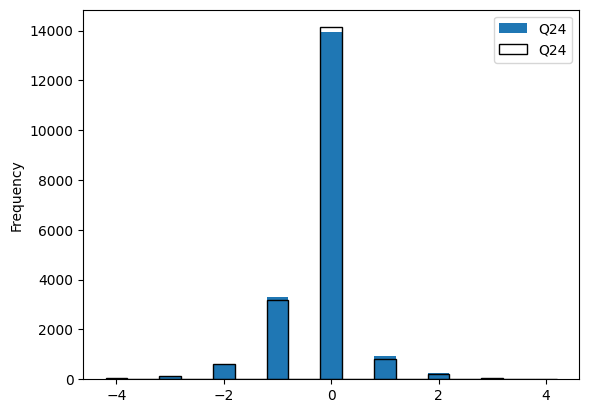

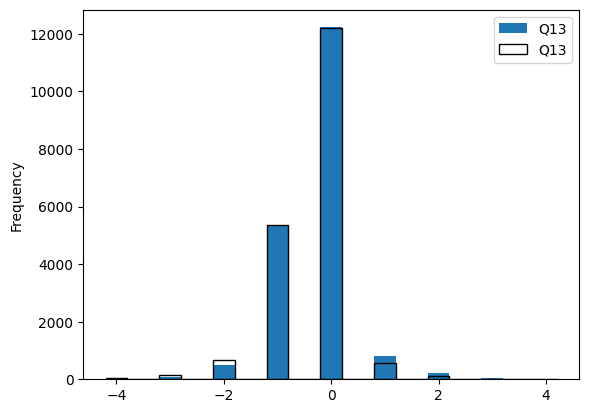

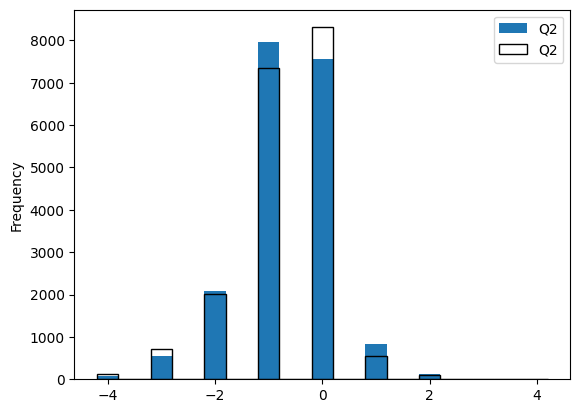

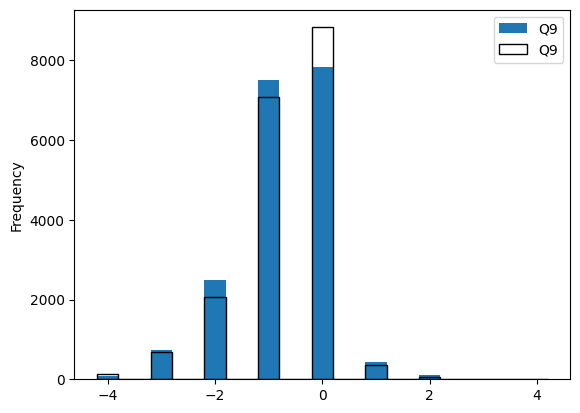

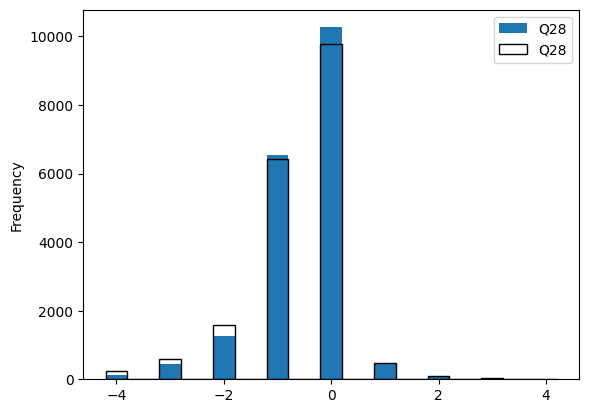

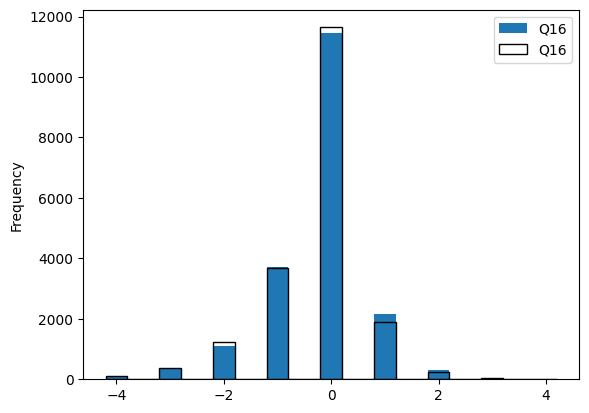

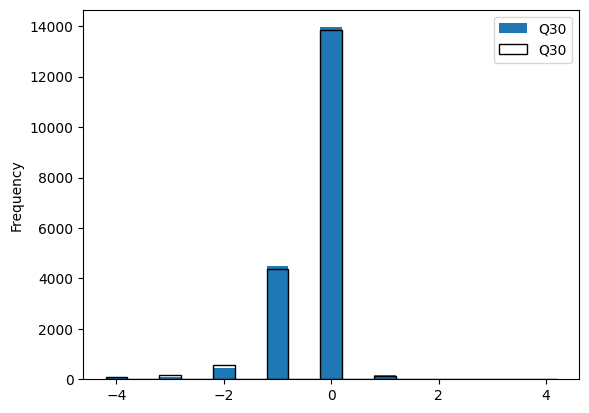

In [12]:
item_dist_pre = df_processed[delta_ids]
item_dist_pre = item_dist_pre.rename(columns=SEE_pre_dict)

item_dist_post = df_processed[delta_ids_post]
item_dist_post = item_dist_post.rename(columns=SEE_post_dict)

pre_or_post_bins = [-4.2,-3.8,-3.2,-2.8,-2.2,-1.8,-1.2,-0.8,-0.2,0.2,0.8,1.2,1.8,2.2,2.8,3.2,3.8,4.2]

for col in item_dist_pre.columns:
    ax = item_dist_pre.plot.hist(column=col, bins=pre_or_post_bins, label='pre')
    item_dist_post.plot.hist(column=col, bins=pre_or_post_bins, ax=ax, facecolor="None", edgecolor='k', label='post')



And now calculate the difference pre to post and plot histograms of that

c:\Users\micha\OneDrive - Imperial College London\US ECLASS\SEE\.venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


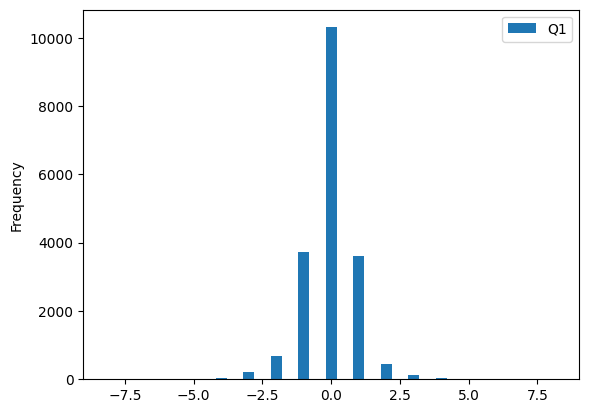

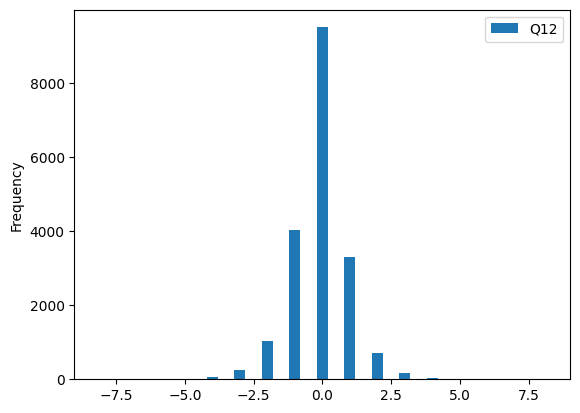

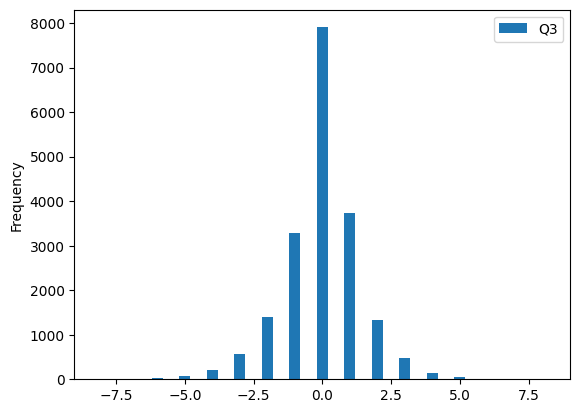

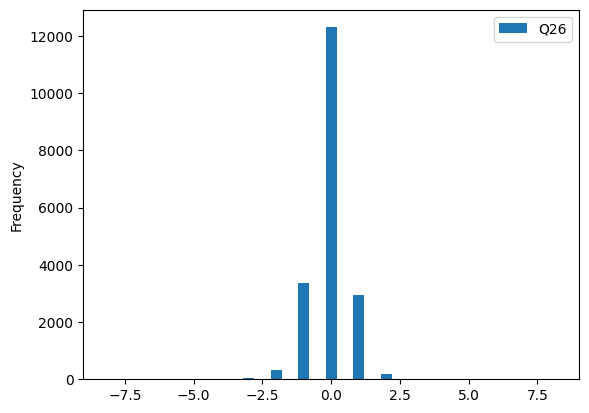

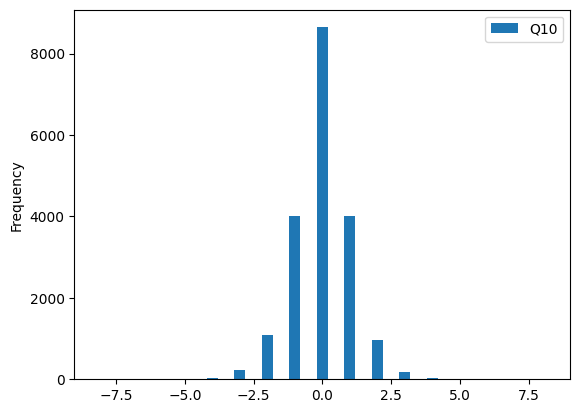

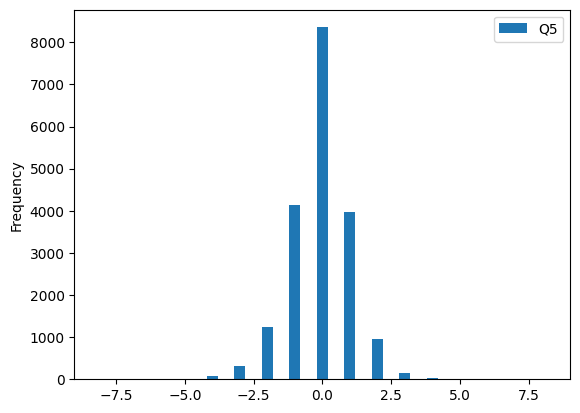

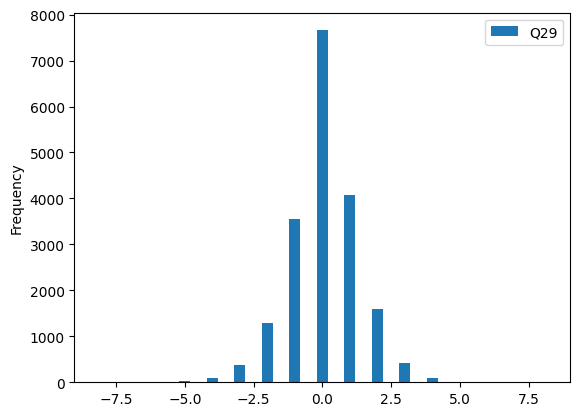

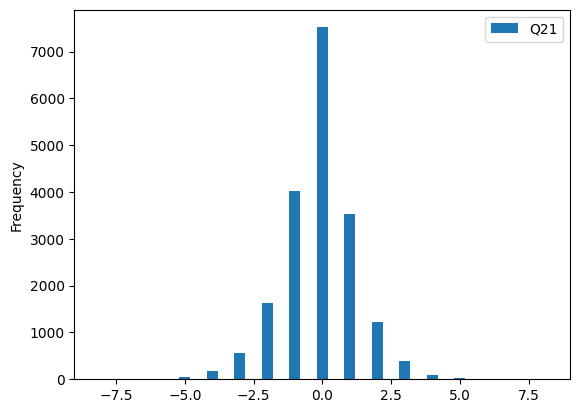

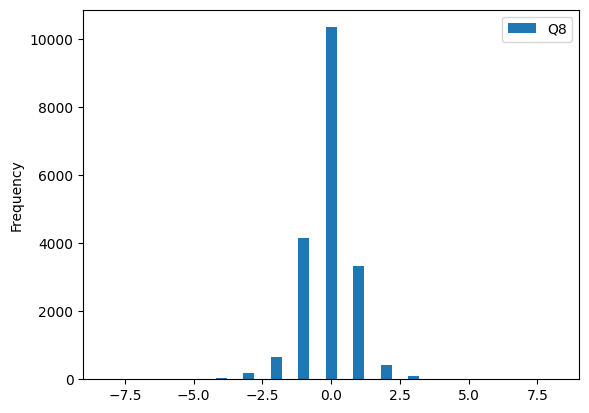

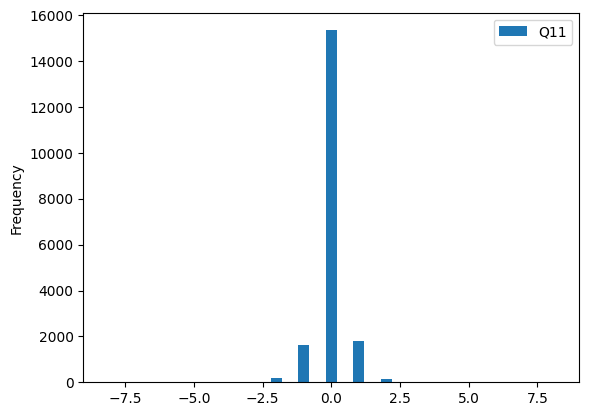

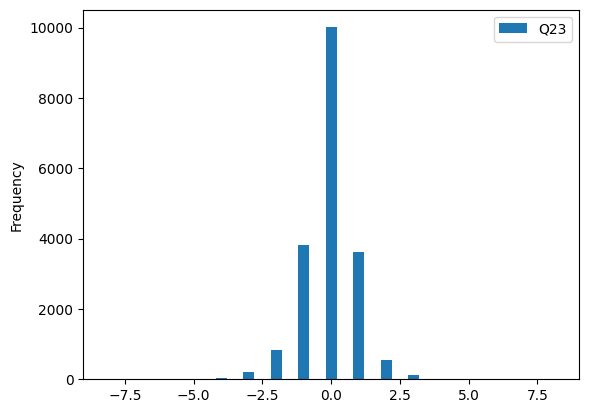

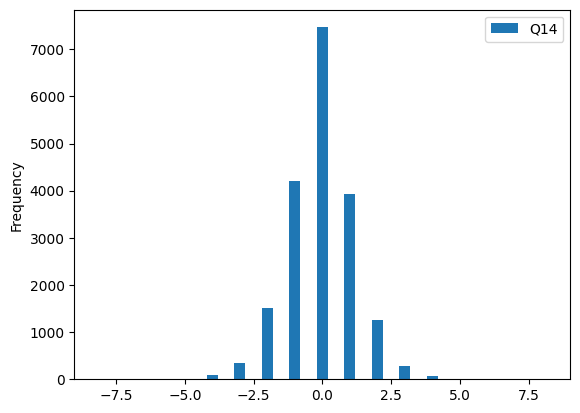

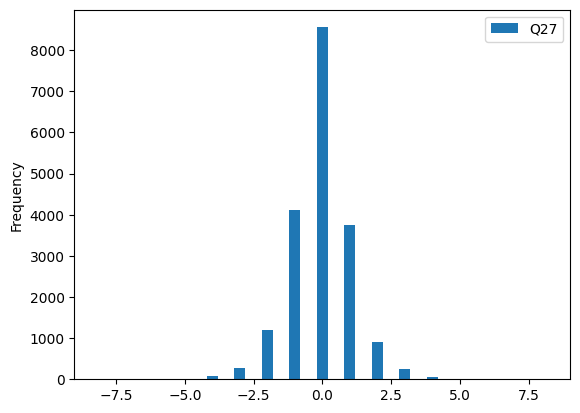

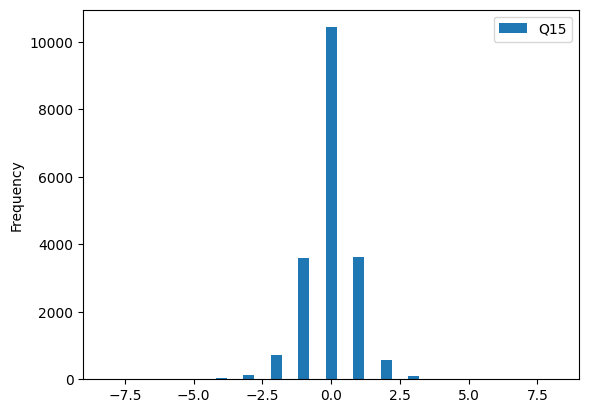

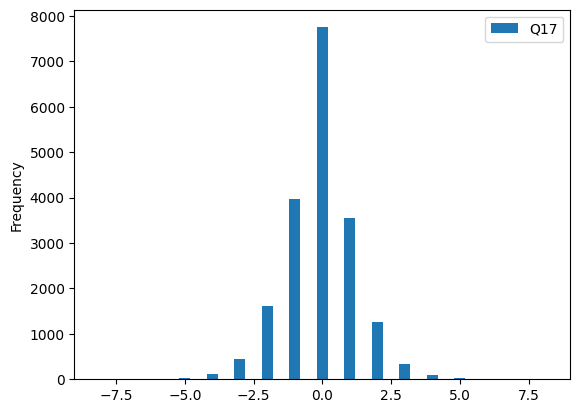

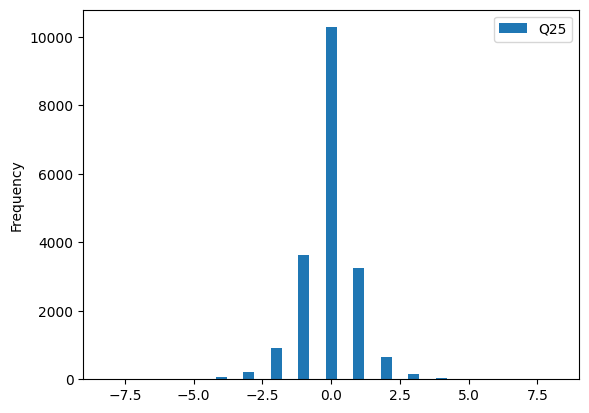

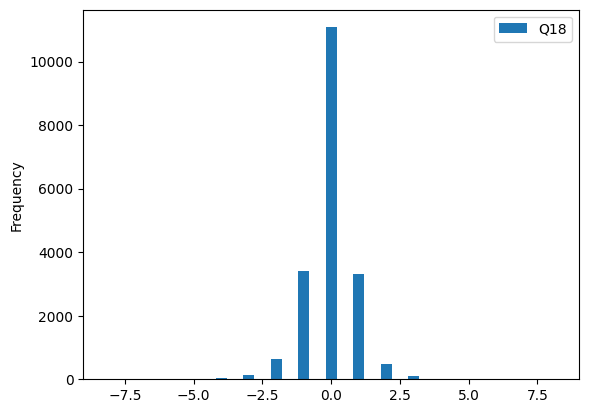

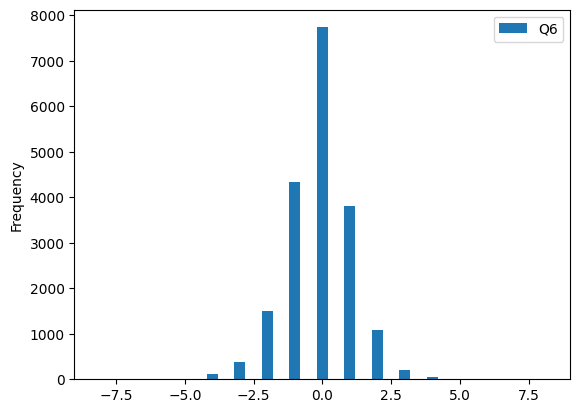

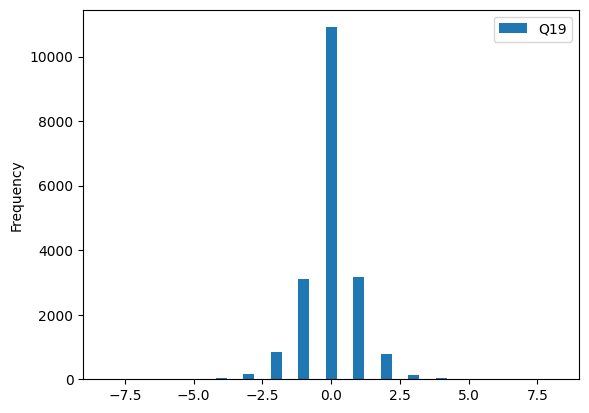

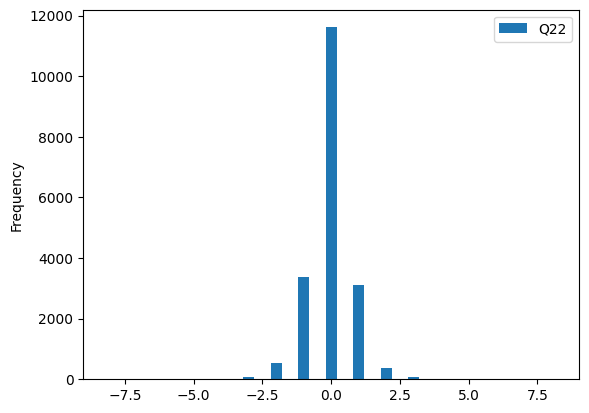

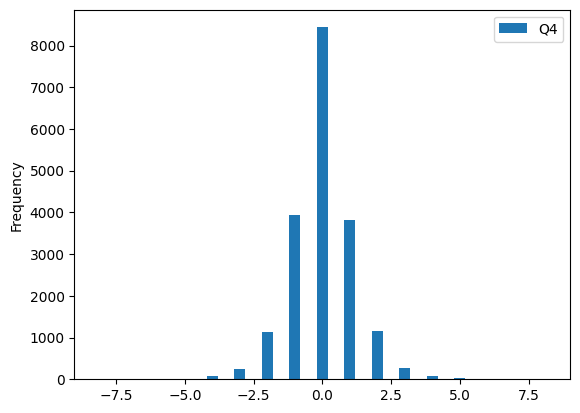

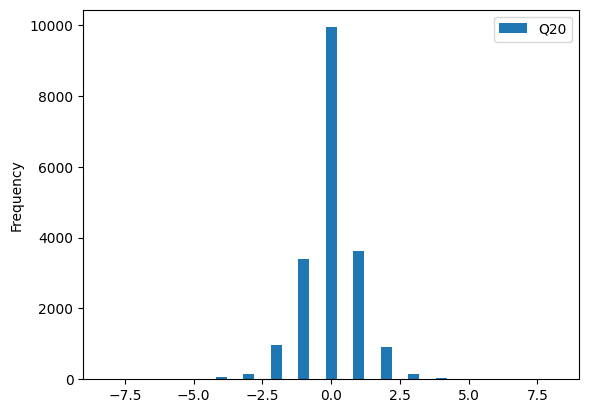

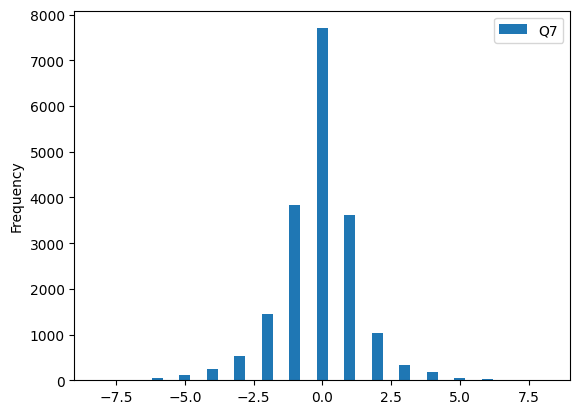

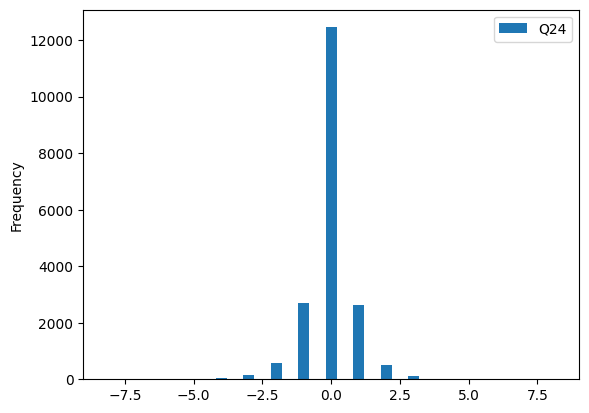

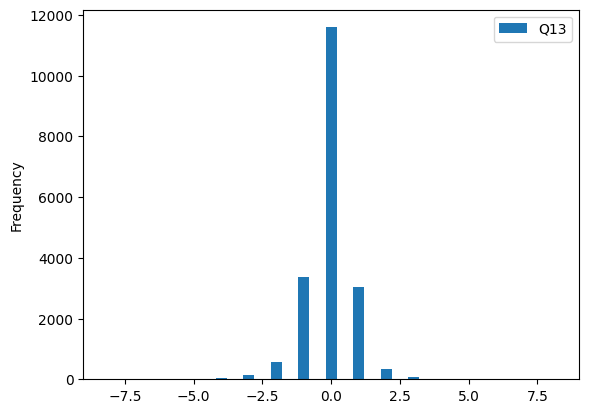

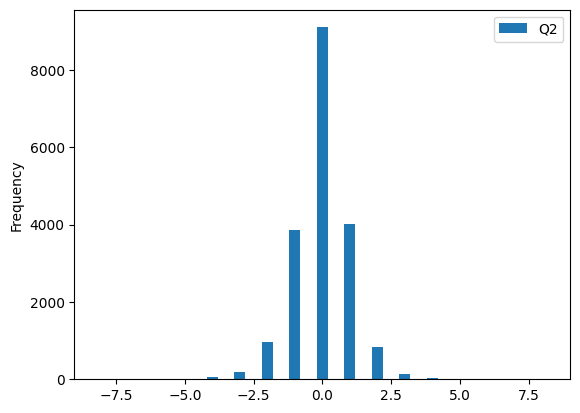

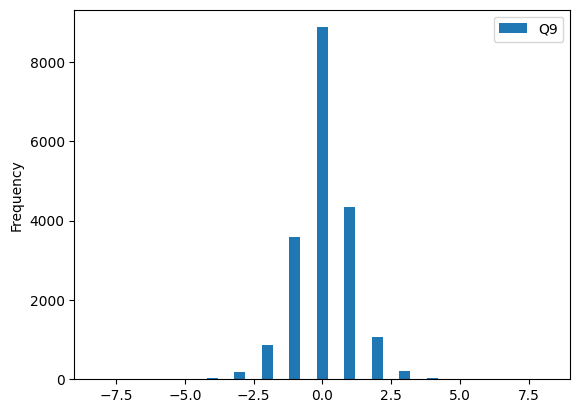

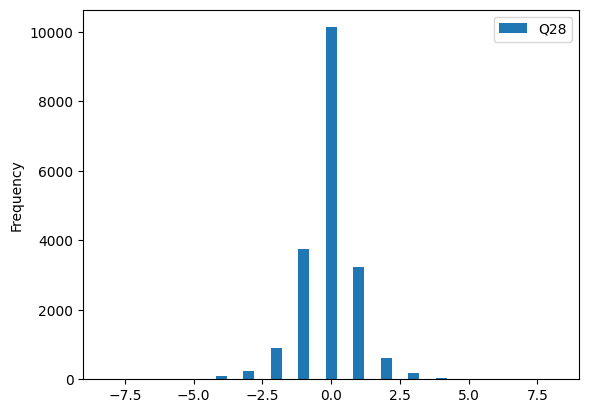

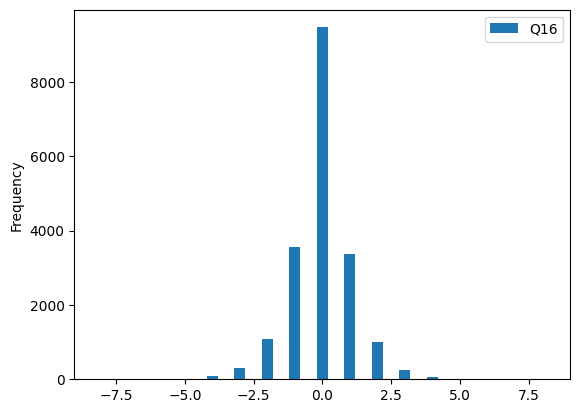

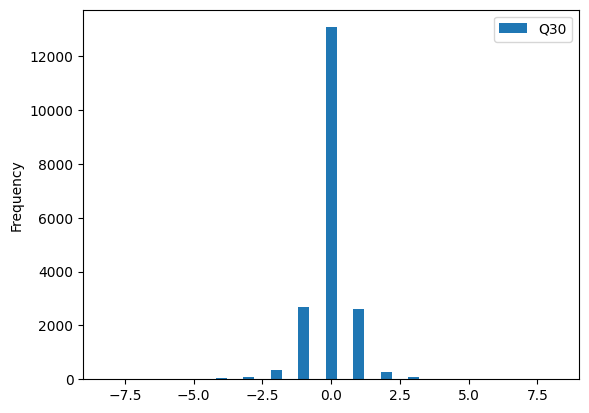

In [13]:
shift = item_dist_post - item_dist_pre
shift_bins = [-8.2,-7.8,-7.2,-6.8,-6.2,-5.8,-5.2,-4.8,-4.2,-3.8,-3.2,-2.8,-2.2,-1.8,-1.2,-0.8,-0.2,0.2,0.8,1.2,1.8,2.2,2.8,3.2,3.8,4.2,4.8,5.2,5.8,6.2,6.8,7.2,7.8,8.2]

for col in shift.columns:
    ax = shift.plot.hist(column=col, bins=shift_bins, density=False)